In [1]:
import numpy as np
import os
import psutil
import time
import subprocess
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import threading

ipykernel

In [2]:
bag_file = "/home/ekaterina/Downloads/nissan_zala_50_zeg_4_0.mcap"
output_dir = "/home/ekaterina/rosbag_record_output"
log_dir = "./logs_rosbag"
ros2_path = "/opt/ros/jazzy/bin/ros2"

In [3]:
# Plots CPU, memory, and disk write metrics over time using line graphs.

def plot_metrics(df):

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    plt.figure(figsize=(8, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(df["timestamp"], df["cpu_usage_percent"], color='orange')
    plt.title("CPU Usage")
    plt.ylabel("CPU (%)")
    plt.grid(False)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    #plt.xticks(rotation=45, ha='right')
    
    plt.subplot(3, 1, 2)
    plt.plot(df["timestamp"], df["mem_usage_mb"], color='blue')
    plt.title("Memory Usage")
    plt.ylabel("Memory (MB)")
    plt.grid(False)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    #plt.xticks(rotation=45, ha='right')
    
    plt.subplot(3, 1, 3)
    plt.plot(df["timestamp"], df["disk_write_kb_per_s"], color='green')
    plt.title("Disk Write Throughput")
    plt.xlabel("Time")
    plt.ylabel("kB/s")
    plt.grid(False)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    #plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

In [37]:
# Monitors CPU usage, memory usage, and disk write throughput of a process by PID at a specified interval.

def monitor(stop_event, monitor_data, interval, pid):
    try:
        proc = psutil.Process(pid) # Get the process object for the given PID
    # Exit if the process no longer exists
    except psutil.NoSuchProcess:
        return 
    
    prev_write_bytes = None # Store previous value of bytes written to disk to handle access errors
    
    # Continuously monitor until stop_event is set
    while not stop_event.is_set():
        try:
            cpu = proc.cpu_percent(interval=interval) # Measure CPU usage percentage over the given interval
            mem = proc.memory_info().rss / (1024 * 1024) # Measure memory usage (resident set size) in megabytes
            
            try:
                write_bytes = proc.io_counters().write_bytes # Get the total number of bytes written to disk by the process
                prev_write_bytes = write_bytes # Update previous value
            except psutil.AccessDenied:
                # If access is denied, use the previous write_bytes value or 0 if not available
                if prev_write_bytes is None:
                    write_bytes = 0
                    prev_write_bytes = 0
                else:
                    write_bytes = prev_write_bytes
            # Process terminated while accessing io_counters
            except psutil.NoSuchProcess:
                break
            
            # Record the current timestamp with millisecond precision
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]

            # Append a tuple of (timestamp, cpu %, memory MB, write bytes) to the shared monitor_data list
            monitor_data.append((timestamp, cpu, mem, write_bytes))
            
        # Exit the loop if the process terminates during monitoring
        except psutil.NoSuchProcess:
            break

In [50]:
# Runs ros2 bag play and ros2 bag record in parallel while monitoring resource usage.

def run_ros2_recorder():
    interval = 0.1 # Sampling interval in seconds for system resource monitoring

    os.makedirs(log_dir, exist_ok=True) # Create the logging directory if it doesn't already exist
    
    # Clear old log files by overwriting them with empty content
    for file in ["monitor_log.csv", "bag_play.log", "rosbag_record.log"]:
        open(os.path.join(log_dir, file), "w").close()

    shutil.rmtree(output_dir, ignore_errors=True) # Delete the previous recording output directory, if it exists

    monitor_data = [] # Shared list to store resource usage data collected during recording
    stop_event = threading.Event() # Event to stop the monitor thread
    
    # Open log files to capture stdout/stderr output from ros2 bag play and record commands
    with open(os.path.join(log_dir, "bag_play.log"), "w") as bag_play_log, \
         open(os.path.join(log_dir, "rosbag_record.log"), "w") as rosbag_record_log:

        # Start playing a ROS 2 bag file in a subprocess
        bag_play = subprocess.Popen(
            [ros2_path, "bag", "play", bag_file],
            stdout=bag_play_log,
            stderr=subprocess.STDOUT
        )

        # Start recording selected topics using ROS 2 bag with Zstd compression
        rosbag_record = subprocess.Popen(
            [
                ros2_path, "bag", "record", "-o", output_dir,
                "--compression-format", "zstd",
                "--compression-mode", "file",
                #"--compression-mode", "message",
                "--storage", "mcap",
                "/nissan/vehicle_speed", "/nissan/vehicle_steering"
            ],
            stdout=rosbag_record_log,
            stderr=subprocess.STDOUT
        )

        # Launch a separate thread to monitor resource usage of the recording process
        monitor_thread = threading.Thread(target=monitor, args=(stop_event, monitor_data, interval, rosbag_record.pid))
        monitor_thread.start()

        bag_play.wait() # Block until the playback process finishes

        rosbag_record.terminate() # Terminate the recording process after playback ends

        stop_event.set() # Signal the monitoring thread to stop
        monitor_thread.join() # Wait for the monitoring thread to finish

    # Convert collected monitoring data into a pandas DataFrame
    df = pd.DataFrame(monitor_data, columns=["timestamp", "cpu_usage_percent", "mem_usage_mb", "disk_write_kb_per_s"])

    # Calculate the write throughput (KB/s) by taking the difference of disk write bytes over time
    df["disk_write_kb_per_s"] = df["disk_write_kb_per_s"].diff().fillna(0) / 1024 / interval

    # Save the monitoring data to a CSV file
    df.to_csv(os.path.join(log_dir, "monitor_log.csv"), index=False)
    
    return df

In [39]:
# Calculates average CPU usage, peak RAM usage, average disk write throughput, and total size of the recorded bag files from monitoring data.

def report_metrics(df):

    cpu_avg = df["cpu_usage_percent"].mean() # Compute average CPU usage over the entire monitoring period
    ram_peak = df["mem_usage_mb"].max() # Find the peak memory usage (in MB) during recording
    write_throughput_avg = df["disk_write_kb_per_s"].mean() # Compute average disk write throughput in kilobytes per second
    
    total_record_size_bytes = 0 # Initialize total recorded data size (in bytes)
    # Walk through the output directory and sum up the sizes of all files
    for root, dirs, files in os.walk(output_dir):
        for f in files:
            total_record_size_bytes += os.path.getsize(os.path.join(root, f))
            
    # Convert total size from bytes to kilobytes
    total_record_size_kb = total_record_size_bytes / 1024
    
    return cpu_avg, ram_peak, write_throughput_avg, total_record_size_kb

In [40]:
# Prints system resource usage statistics and total size of the recorded bag files.

def print_metrics(df):
    # Calculate metrics from the monitoring DataFrame
    cpu_avg, ram_peak, write_throughput_avg, total_record_size_mb = report_metrics(df)
    print(f"Average CPU usage         : {cpu_avg:.2f}%")
    print(f"Peak RAM usage            : {ram_peak:.2f} MB")
    print(f"Average write throughput  : {write_throughput_avg:.2f} KB/s")
    print(f"Total record size         : {total_record_size_mb:.2f} KB")   

Case: "--compression-mode", "message"

In [44]:
metrics = run_ros2_recorder()

In [45]:
print_metrics(metrics)

Average CPU usage         : 2.61%
Peak RAM usage            : 55.86 MB
Average write throughput  : 4.02 KB/s
Total record size         : 378.89 KB


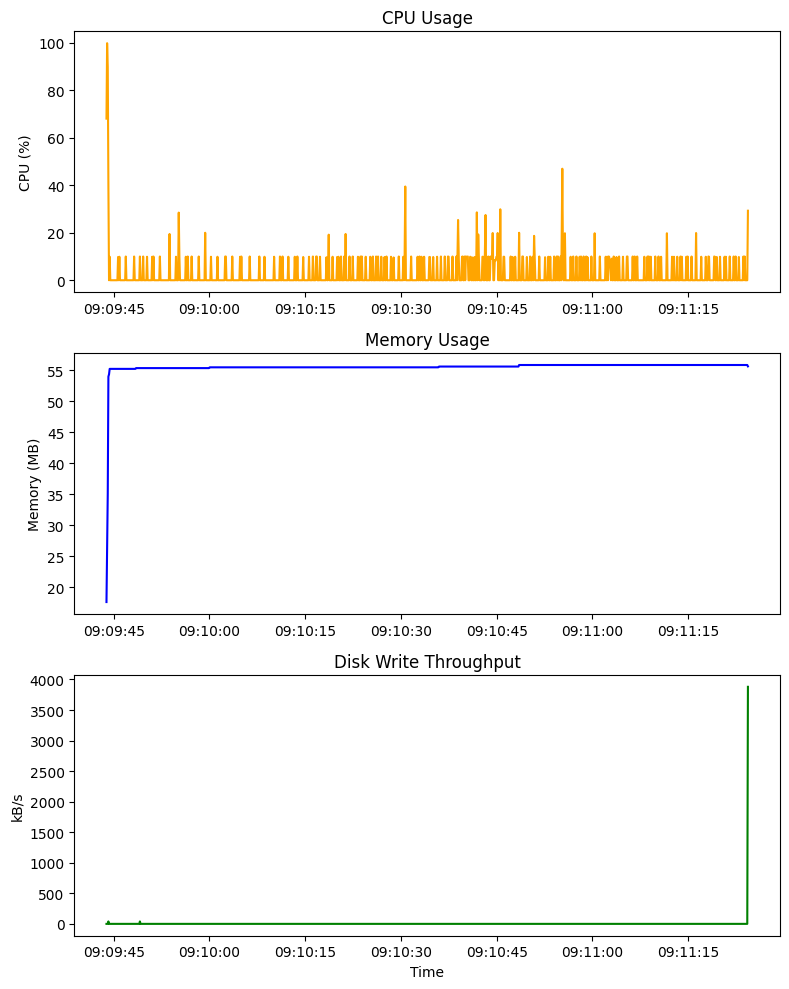

In [46]:
plot_metrics(metrics)

In [47]:
cpu, ram, throughput, size = [], [], [], []
for _ in range(50):
    metrics = run_ros2_recorder()
    c, r, t, s = report_metrics(metrics)
    cpu.append(c)
    ram.append(r)
    throughput.append(t)
    size.append(s)
    time.sleep(10)

In [48]:
print(f"Average CPU usage         : {np.median(cpu):.2f}%")
print(f"Peak RAM usage            : {np.median(ram):.2f} MB")
print(f"Average write throughput  : {np.median(throughput):.2f} KB/s")
print(f"Total record size         : {np.median(size):.2f} KB")

Average CPU usage         : 3.08%
Peak RAM usage            : 55.94 MB
Average write throughput  : 4.07 KB/s
Total record size         : 380.95 KB


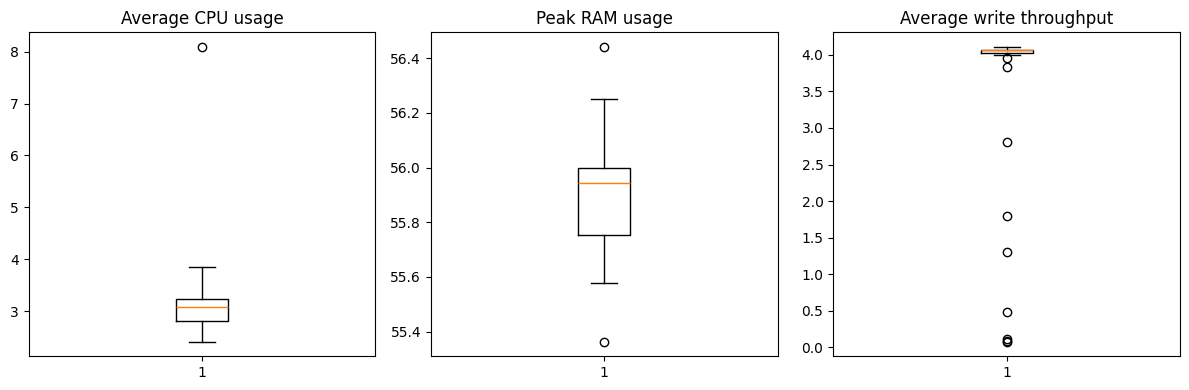

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].boxplot(cpu)
axs[0].set_title('Average CPU usage')

axs[1].boxplot(ram)
axs[1].set_title('Peak RAM usage')

axs[2].boxplot(throughput)
axs[2].set_title('Average write throughput')

plt.tight_layout()
plt.show()

Case: "--compression-mode", "file"

In [51]:
metrics = run_ros2_recorder()

In [52]:
print_metrics(metrics)

Average CPU usage         : 2.71%
Peak RAM usage            : 55.84 MB
Average write throughput  : 4.63 KB/s
Total record size         : 111.34 KB


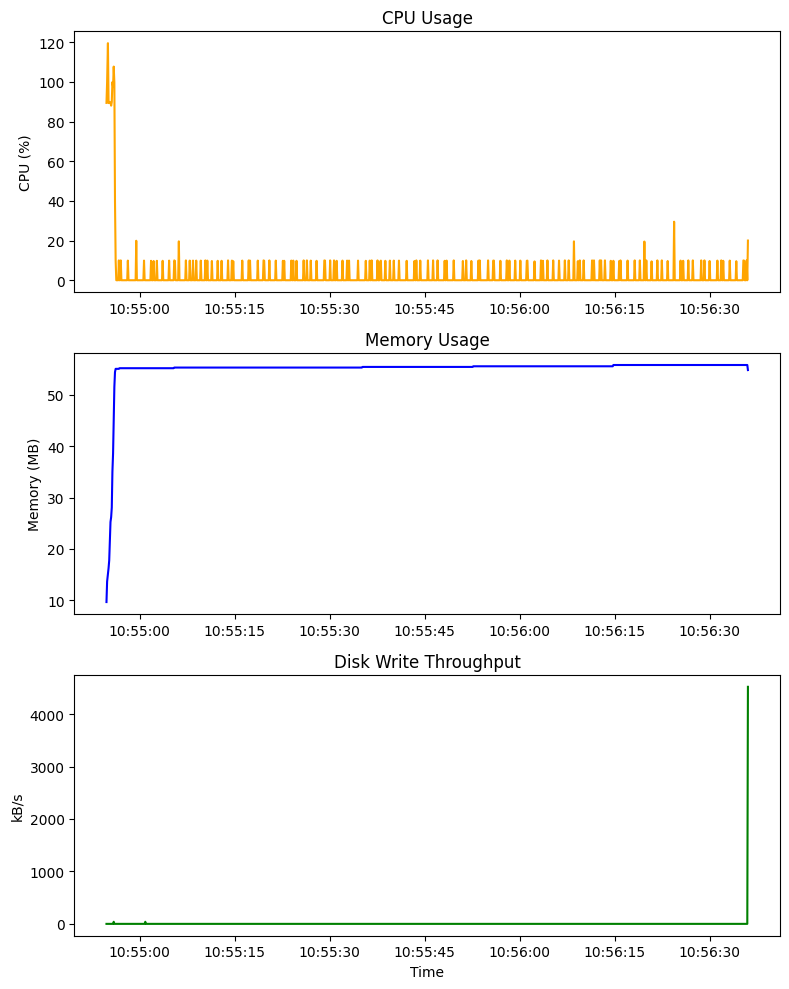

In [53]:
plot_metrics(metrics)

In [54]:
cpu, ram, throughput, size = [], [], [], []
for _ in range(50):
    metrics = run_ros2_recorder()
    c, r, t, s = report_metrics(metrics)
    cpu.append(c)
    ram.append(r)
    throughput.append(t)
    size.append(s)
    time.sleep(10)

In [55]:
print(f"Average CPU usage         : {np.median(cpu):.2f}%")
print(f"Peak RAM usage            : {np.median(ram):.2f} MB")
print(f"Average write throughput  : {np.median(throughput):.2f} KB/s")
print(f"Total record size         : {np.median(size):.2f} KB")

Average CPU usage         : 2.27%
Peak RAM usage            : 55.80 MB
Average write throughput  : 4.67 KB/s
Total record size         : 111.41 KB


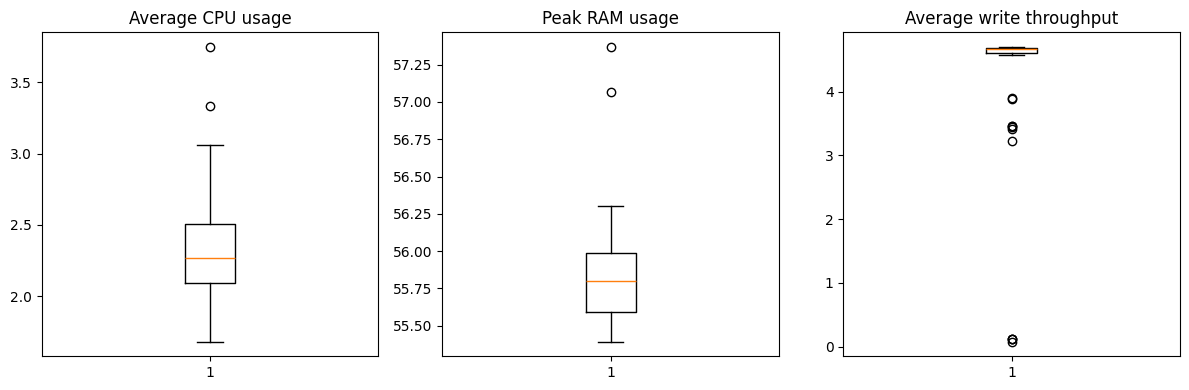

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].boxplot(cpu)
axs[0].set_title('Average CPU usage')

axs[1].boxplot(ram)
axs[1].set_title('Peak RAM usage')

axs[2].boxplot(throughput)
axs[2].set_title('Average write throughput')

plt.tight_layout()
plt.show()

Change Kernel!

In [1]:
import numpy as np
import os
import psutil
import time
import subprocess
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import threading

In [2]:
bag_file = "/home/ekaterina/Downloads/nissan_zala_50_zeg_4_0.mcap"
output_dir = "/home/ekaterina/red_data"
config_path = "./config.yaml"
log_dir = "./logs"
ros2_path = "/opt/ros/jazzy/bin/ros2"

In [3]:
# Plots CPU, memory, and disk write metrics over time using line graphs.

def plot_metrics(df):

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    plt.figure(figsize=(8, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(df["timestamp"], df["cpu_usage_percent"], color='orange')
    plt.title("CPU Usage")
    plt.ylabel("CPU (%)")
    plt.grid(False)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    #plt.xticks(rotation=45, ha='right')
    
    plt.subplot(3, 1, 2)
    plt.plot(df["timestamp"], df["mem_usage_mb"], color='blue')
    plt.title("Memory Usage")
    plt.ylabel("Memory (MB)")
    plt.grid(False)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    #plt.xticks(rotation=45, ha='right')
    
    plt.subplot(3, 1, 3)
    plt.plot(df["timestamp"], df["disk_write_kb_per_s"], color='green')
    plt.title("Disk Write Throughput")
    plt.xlabel("Time")
    plt.ylabel("kB/s")
    plt.grid(False)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    #plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

In [10]:
# Monitors CPU usage, memory usage, and disk write throughput of a process by PID at a specified interval.

def monitor(stop_event, monitor_data, interval, pid):
    try:
        proc = psutil.Process(pid) # Get the process object for the given PID
    # Exit if the process no longer exists
    except psutil.NoSuchProcess:
        return

    prev_write_bytes = 0 # Store previous value of bytes written to disk to handle access errors

    # Continuously monitor until stop_event is set
    while not stop_event.is_set():
        try:
            # Get the main process and all of its child processes (recursively)
            processes = [proc] + proc.children(recursive=True)
            cpu_total = 0
            mem_total = 0
            write_bytes_total = 0

            for p in processes:
                try:
                    cpu_total += p.cpu_percent(interval=None if p != proc else interval) # Accumulate CPU usage, apply interval only to the main process
                    mem_total += p.memory_info().rss # Accumulate memory usage (resident set size)
                    write_bytes_total += p.io_counters().write_bytes # Accumulate bytes written to disk
                # Skip if process no longer exists or access is denied
                except (psutil.NoSuchProcess, psutil.AccessDenied):
                    continue

            mem_total /= 1024 * 1024  # Convert memory from bytes to megabytes

            # Use previous write bytes if current value is unavailable (0)
            write_bytes = write_bytes_total if write_bytes_total else prev_write_bytes
            prev_write_bytes = write_bytes_total
            
            # Record the current timestamp with millisecond precision
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]
            
            # Append a tuple of (timestamp, cpu %, memory MB, write bytes) to the shared monitor_data list
            monitor_data.append((timestamp, cpu_total, mem_total, write_bytes))

        # Exit the loop if the process terminates during monitoring
        except psutil.NoSuchProcess:
            break

In [5]:
# Runs ros2 bag play and agent in parallel while monitoring resource usage.

def run_agent_recorder():
    interval = 0.1 # Sampling interval in seconds for monitoring

    os.makedirs(log_dir, exist_ok=True) # Create logging directory if it doesn't exist
    
    # Clear old log files by overwriting them with empty content
    for file in ["monitor_log.csv", "bag_play.log", "agent_record.log"]:
        open(os.path.join(log_dir, file), "w").close()

    shutil.rmtree(output_dir, ignore_errors=True) # Delete the previous recording output directory, if it exists

    monitor_data = [] # Shared list to store resource usage data collected during recording
    stop_event = threading.Event() # Event to stop the monitor thread
    
    # Open log files to capture stdout/stderr output from ros2 bag play and agent commands
    with open(os.path.join(log_dir, "bag_play.log"), "w") as bag_play_log, \
         open(os.path.join(log_dir, "agent_record.log"), "w") as agent_record_log:

        # Start playing a ROS 2 bag file in a subprocess
        bag_play = subprocess.Popen(
            [ros2_path, "bag", "play", bag_file],
            stdout=bag_play_log,
            stderr=subprocess.STDOUT
        )

        # Start recording selected topics using agent with Zstd compression
        agent = subprocess.Popen(
            [
                "ros2", "run", "reductstore_agent", "recorder",
                "--ros-args", "--params-file", config_path
            ],
            stdout=agent_record_log,
            stderr=subprocess.STDOUT
        )
             
        # Launch a separate thread to monitor resource usage of the recording process
        monitor_thread = threading.Thread(target=monitor, args=(stop_event, monitor_data, interval, agent.pid))
        monitor_thread.start()

        bag_play.wait() # Block until the playback process finishes

        agent.terminate() # Terminate the recording process after playback ends

        stop_event.set() # Signal the monitoring thread to stop
        monitor_thread.join() # Wait for the monitoring thread to finish

    # Convert collected monitoring data into a pandas DataFrame
    df = pd.DataFrame(monitor_data, columns=["timestamp", "cpu_usage_percent", "mem_usage_mb", "disk_write_kb_per_s"])

    # Calculate the write throughput (KB/s) by taking the difference of disk write bytes over time
    df["disk_write_kb_per_s"] = df["disk_write_kb_per_s"].diff().fillna(0) / 1024 / interval

    # Save the monitoring data to a CSV file
    df.to_csv(os.path.join(log_dir, "monitor_log.csv"), index=False)
    
    return df

In [6]:
# Calculates average CPU usage, peak RAM usage, and average disk write throughput from monitoring data.

def report_metrics(df):

    cpu_avg = df["cpu_usage_percent"].mean() # Compute average CPU usage over the entire monitoring period
    ram_peak = df["mem_usage_mb"].max() # Find the peak memory usage (in MB) during recording
    write_throughput_avg = df["disk_write_kb_per_s"].mean() # Compute average disk write throughput in kilobytes per second
    
    return cpu_avg, ram_peak, write_throughput_avg

In [7]:
# Prints system resource usage statistics and total size of the recorded bag files.

def print_metrics(df):
    # Calculate metrics from the monitoring DataFrame
    cpu_avg, ram_peak, write_throughput_avg = report_metrics(df)
    print(f"Average CPU usage         : {cpu_avg:.2f}%")
    print(f"Peak RAM usage            : {ram_peak:.2f} MB")
    print(f"Average write throughput  : {write_throughput_avg:.2f} KB/s")

In [8]:
metrics_agent = run_agent_recorder()

In [9]:
print_metrics(metrics_agent)

Average CPU usage         : 0.17%
Peak RAM usage            : 119.07 MB
Average write throughput  : 0.78 KB/s


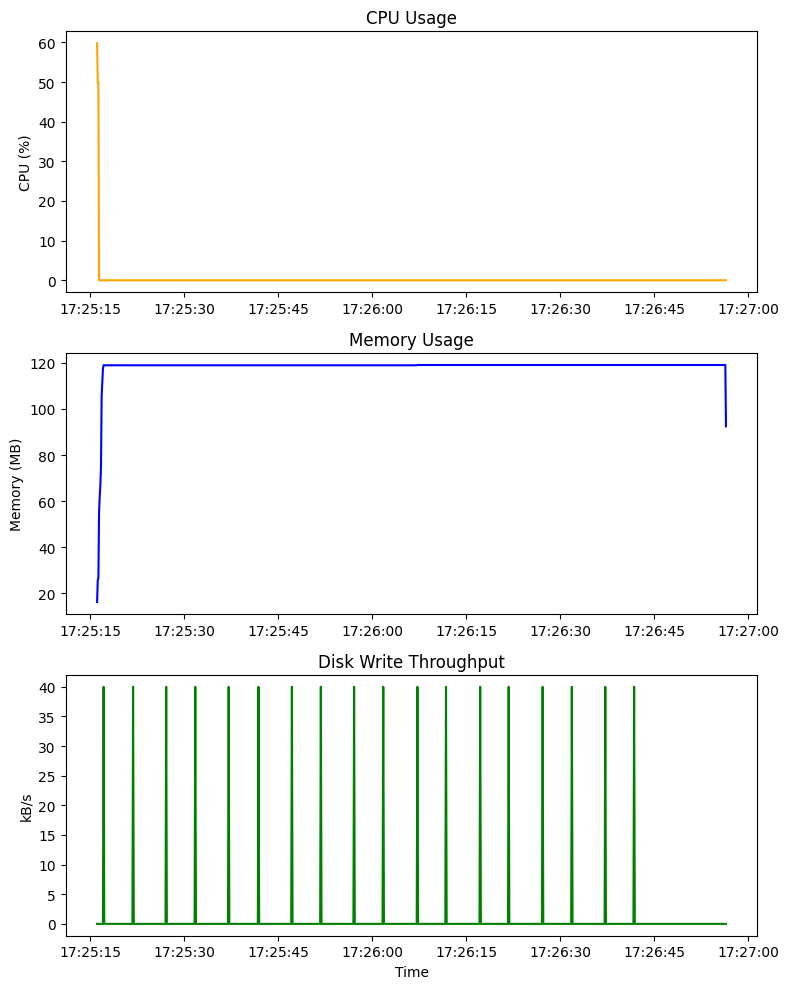

In [11]:
plot_metrics(metrics_agent)